In [304]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import nilearn

from nilearn.datasets import fetch_haxby
from nilearn import input_data, plotting, image
from nilearn.image import load_img
from nilearn.image.image import mean_img
from nilearn.plotting.img_plotting import plot_epi, plot_roi
import nibabel as nib

# По использованию nilearn есть notebook на диске

In [170]:
warnings.filterwarnings('ignore')

\section{Постановка задачи}
Исследуется задача декодирования временного ряда. Пусть имеется некоторый процесс (активность головного мозга):
$$\mathcal{V}(\tau),~\tau \in \mathbb{R}$$
Тогда данные выборки ~--- это регистрируемый сигнал, то есть реализация процесса $\mathcal{V}(\tau)$:
$$\bm{X} = \left[\bm{x}_1,\dots \bm{x}_{T}\right], \quad \bm{x}_t \in \mathbb{R}^K$$
Здесь $K$ ~--- число каналов. $T$ ~--- число измерений сигнала с частотой $\mu$ за время $\tau$:
$$T = \tau \mu$$
$$\bm{x}_{\tau \mu} \approx \mathcal{V}(\tau)$$
\subsection{Задача классификации отрезков регистрируемого сигнала}
В данной задаче имеется выборка регистрируемых отрезков сигнала, 
требуется классифицировать каждый наблюдаемый временной отрезок. 
Введем следующие обозначения:
Пусть имеется $N$ зарегистрированных реализаций некоторого процесса:
$$\bm{X} = \{\bm{X}_1,\dots, \bm{X}_N\},$$
$$\bm{X}_i = \left[\bm{x}^i_1,\dots, \bm{x}^i_{T}\right], \quad \bm{x}^i_t \in \mathbb{R}^K,$$
$$\bm{Y} = \left[y_1, \dots, y_{N}\right]^{\T}, \quad y_i \in \{1,\dots, C\},$$
Здесь $y_i$~--- целевая метка класса $i$-го зарегистрированного сигнала. $C$ ~--- число классов в задаче классификации сигнала. 

Имеется соответственно выборка $\mathcal{D} = \{y_i, \bm{X}_i\},~  i = \overline{1,N}$
Требуется построить отображение $f_\theta$, которое учитывало 
бы пространственно-временные характеристиик между временными рядами от датчиков:
$$f_\theta: \bm{X} \rightarrow \{1,\dots, C\}$$ 
\subsection{Задача классификации активности}
В данной задаче предполагается получение классификации для каждого отсчета 
времени наблюдения.
Пусть имеется некоторый процесс и зарегистрированная реализация данного 
процесса в виде дискретного числа измерений. Каждому измерению соответствует
класс активности. Формально:
$$\bm{X} = \{\bm{x}_1,\dots, \bm{x}_{T}\}, \quad \bm{x}_t \in \mathbb{R}^K,$$
$$\bm{Y} = \left[y_1, \dots, y_{T}\right]^{\T},\quad y_t \in \{1,\dots, C\},$$
Здесь $C$ ~--- число классов в задаче классификации активности. 
Выборка $\mathcal{D} = \{y_t, \bm{x}_t\}_{t=1}^T$

Для набора данных, описанного выше, требуется построить отображение $f_\theta$, которое учитывало 
бы пространственно-временные характеристиик между временными рядами сигнала:
$$f_\theta: \bm{X} \rightarrow \bm{Y}$$ 

\subsection{Задача классификации временных рядов фМРТ}
Пусть имеется $N$ многомерных временных рядов снимков фМРТ длины $T$:
\begin{equation*} 
	\bm{S} = \{\bm{S}_1,\dots, \bm{S}_{N}\},
\end{equation*}
\begin{equation*}
	\bm{S}_i = [\bm{s}_{1}^i, \ldots, \bm{s}_{T}^i], \quad
	\bm{s}_{t}^i \in \mathbb{R}^{X \times Y \times Z},
\end{equation*}
$$\bm{Y} = \left[y_1, \dots, y_{N}\right]^{\T},\quad y_i \in \{1,\dots, C\},$$
где $X, Y$ и $Z$~--- размерности воксельного изображения, 
$y_i$~--- целевая метка $i$-ой последовательности фМРТ снимков. 
$C$ ~--- число классов в задаче классификации временных рядов фМРТ. 

Имеется соответственно выборка $\mathcal{D} = \{y_i, \bm{S}_i\},~ i = \overline{1,N}$.
Требуется построить отображение $f_\theta$, которое учитывало 
бы пространственно-временные характеристиик между временными рядами фМРТ:
$$f_\theta: \bm{S} \rightarrow \{1,\dots, C\}$$  

\subsection{Задача классификации отрезков временного ряда фМРТ одного испытуемого}
С учётом индивидуальных анатомических особенностей головы и уникальной реакции на предъявляемые стимулы для каждого человека, 
требуется разработать модель классификации, которую можно настроить индивидуально под данные конкретного индивида. 
Формализуем задачу.

Предположим, что у нас имеется одно непрерывное измерение фМРТ с дискретным представлением времени для конкретного человека:
\begin{equation*}
	\bm{S} = [\bm{s}_{1}, \ldots, \bm{s}_{T}], \quad \bm{s}_{t} \in \mathbb{R}^{X \times Y \times Z},
\end{equation*}
где $X, Y$ и $Z$~--- размерности воксельного изображения, $T$~--- длина временного ряда фМРТ. 
В ходе процедуры фМРТ человеку демонстрируются стимулы различных категорий. 
Либо человек выполняет моторные или когнетивные задания различных типов. 
Для удобства дальнейшего изложения мы будем говорить в парадигме стимулов.
Пусть имеется временной ряд стимулов:
\begin{equation*}
	\bm{Q} = [{q}_{1}, \ldots, {q}_{T}], \quad {q}_{t} \in \{0,\dots, C},
\end{equation*}
где ${1,\dots, C}$ ~--- множество классов стимулов, которые демонстрируют испытуемому. $0$~--- класс, обозначающий моменты отдыха испытуемого.
Необходимо разделить временной ряд на отрезки фиксированной длины $\tau$ в соответствии с категориями представленных стимулов.

Пусть теперь имеется $N$ отрезков многомерного временного ряда фМРТ длины $\tau$, полученных при решении предыдущей задачи:
\begin{equation*} 
	\hat{\bm{S}} = \{\bm{S}_1,\dots, \bm{S}_{N}\},
\end{equation*}
\begin{equation*}
	\bm{S}_i = [\bm{s}_{1}^i, \ldots, \bm{s}_{\tau}^i], \quad
	\bm{s}_{t}^i \in \mathbb{R}^{X \times Y \times Z},
\end{equation*}
$$\bm{Y} = \left[y_1, \dots, y_{N}\right]^{\T},\quad y_i \in \{1,\dots, C\},$$
где $y_i$~--- целевая метка класса последовательности фМРТ снимков $\bm{S}_i$.  

Имеется соответственно выборка $\mathcal{D} = \{y_i, \bm{S}_i\},~ i = \overline{1,N}$.
Требуется построить отображение $f_\theta$, которое учитывало 
бы пространственно-временные характеристиик в задаче классификации многомерных временных рядов:
$$f_\theta: \hat{\bm{S}} \rightarrow \{1,\dots, C\}$$  

\section{Предлагаемый метод классификации временных рядов фМРТ}
\subsection{Сегментация данных фМРТ}
\textit{TODO: формализовать идею}
При работе с данными фМРТ часто возникает проблема сегментации длинной 
последовательности фМРТ снимков на отрезки меньшей длины для последующей классификации.
Данная задача акутуальна в работе, поскольку медицинских данных обычно не хватает на практике для обучения 
сложных моделей. Будем для простоты считать, что в данных имеется разметка моментов наблюдения стимулов и моментов отдыха испытуемого.
Один из подходов решения данной проблемы отбирать сегменты соотвествующие определенному классу стимулов и брать некоторую окрестность с 
моментами отдыха испытуемого. 

Далее необходимо проверить, что средняя по вокселям дисперсия привышает заданный порог. 
Данное условие означает, что во время просмотра стимулов активизировалось область мозга достаточного объема для последующего анализа и классификации.
Этот метод может быть адаптирован в зависимости от конкретных требований задачи. 
Важно отметить, что подбор порога может потребовать тестирования и анализа результатов на валидационных данных.
Возможно использование перекрытия между сегментами, чтобы учесть динамику изменений в данных и сделать классификацию более устойчивой.

\subsection{Маскирование снимков фМРТ}

\begin{figure}[h!]
    \centering
    \includegraphics[width=0.8\textwidth]{cross_correlations.pdf}
    \caption{Regions of interest obtained as a result of cross-correlation analysis with the video sequence character}
\end{figure}
\begin{figure}[h!]
    \centering
    \includegraphics[width=0.8\textwidth]{cross_correlations_trash.pdf}
    \caption{Regions of interest obtained as a result of cross-correlation analysis with noise}
\end{figure}

## Haxby datset

Во время эксперимента испытуемым показывали различные изображения. Категории изображений представляются в метках, а именно каждая метка соответствует определенной категории изображений. Например, если в эксперименте использовались изображения различных объектов, метки могут обозначать какие-то определенные объекты. Таким образом, задача классификации заключается в том, чтобы по фМРТ-снимкам предсказать, какой класс картинок наблюдал испытуемый.

Классы:
- bottle
- cat
- chair
- face
- house
- scissors
- scrambledpix
- shoe
Также присутствует rest, когда испытуемому ничего не показывали

In [291]:
class haxby_dataset():
    def __init__(self):
        path = '\data_fmri'
        self.data_files = fetch_haxby(data_dir=path, subjects=(1, 2, 3, 4, 5, 6), fetch_stimuli=True, url=None, resume=True, verbose=1)


    def get_sub_data(self, num):
        # пути к данным
        fmri_data = self.data_files['func'][num-1]  # фМРТ-снимки
        labels = self.data_files['session_target'][num-1] # метки классов

        fmri_img = nib.load(fmri_data)
        fmri_array = fmri_img.get_fdata()
        labels_frame = pd.read_csv(labels, delimiter=' ')
        return fmri_array, labels_frame
    

    def plot_stimuli(self):
        stimulus_information = self.data_files.stimuli

        for stim_type in stimulus_information:
            # skip control images, there are too many
            if stim_type != 'controls':

                file_names = stimulus_information[stim_type]
                file_names = file_names[0:16]
                fig, axes = plt.subplots(4, 4)
                fig.suptitle(stim_type)

                for img_path, ax in zip(file_names, axes.ravel()):
                    ax.imshow(plt.imread(img_path), cmap=plt.cm.gray)

                for ax in axes.ravel():
                    ax.axis("off")
        plt.show()


In [292]:
dataset = haxby_dataset()
datafiles = dataset.data_files

In [301]:
# Описание датасета
#print(datafiles['description'])

In [293]:
# отрисовка стимулов 
#dataset.plot_stimuli()

Получим данные первого испытуемого

In [294]:
fmris, labels = dataset.get_sub_data(1)

In [235]:
fmris.shape

(40, 64, 64, 1452)

In [175]:
labels.head()

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0


---

### Маски активности
A common operation in fMRI analyses is masking: extracting particular voxels from the entire dataset, usually based on a binary brain mask. Masking, at least in fMRI analyses, is often done on the spatial dimensions of 4D images; as such, masking can be seen as a operation that takes in a 4D image with spatial dimensions  X×Y×Z  and temporal dimension  T  and returns a  T×K  2D array, where  K  is the number of voxels that "survived" (for lack of a better word) the masking procedure.

Reasons to mask your data could be, for example, to exclude non-brain voxels (like in skullstripping) or to perform confirmatory region-of-interest (ROI) analyses, or to extract one or multiple "seed regions" for connectivity analyses.

Nilearn provides several functions and classes that perform masking, which differ in how extensive they are (some only perform masking on a single image, others do this for multiple images at the same time, and/or may additionally perform preprocessing steps). Importantly, all take in a 4D niimg-like object and return a 2D numpy array.

We'll first take a look at the most simple and low-level implementation: apply_mask. This function takes in a 4D image (which will be masked), a binary 3D image (i.e., with only zeros and ones, where ones indicate that they should be included) as mask, and optionally a smoothing kernel size (FWHM in millimeters) and returns a masked 2D array. Let's do this for our data (func_img_run1) using the brain mask (func_mask) you computed earlier.

The ventral temporal cortex. Эта маска была создана в рамках исследования Haxby(2001) и выделяет часть мозга, специализирующуюся на обработке визуальной информации, и которая содержит области, чувствительные к различным типам категорий изображений. Далее проводим анализ для первого испытуемого

In [195]:
vt_mask_filename = load_img(datafiles.mask_vt[0])
func_filename = datafiles.func[0]
mean_haxby = mean_img(func_filename)
vt_mask = vt_mask_filename.get_fdata().shape

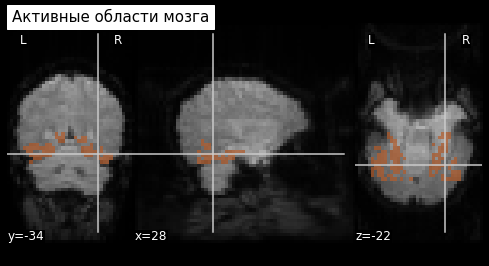

In [392]:
plot_roi(vt_mask_filename, bg_img=mean_haxby, title = 'Активные области мозга', draw_cross=True, 
                  cmap='Paired')

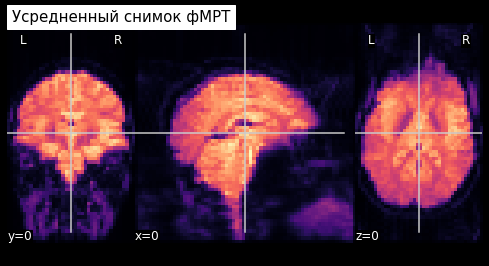

In [398]:
plot_epi(mean_haxby, cut_coords=(0, 0, 0), cmap='magma', title = 'Усредненный снимок фМРТ')

In [197]:
# Применение маски активации к фмрт снимкам
masker = input_data.NiftiMasker(mask_img=vt_mask_filename, standardize=True)
fmri_masked = masker.fit_transform(func_filename)

In [153]:
fmri_masked.shape

(1452, 577)

---

### Подготовка данных
Данные первого испытуемого хранятся в переменных fmris, labels, разделим последовательность на временные ряды по классам

In [250]:
# Определение классов и их индексов
unique_classes = np.unique(labels['labels'].values)

# Создание словаря, в котором ключами будут классы, а значениями будут соответствующие им временные ряды
class_data = {cls: [] for cls in unique_classes}

current_class = labels['labels'].values[0]
current_sequence = [fmris[:,:,:,0]]

# Итерация по данным и создание временных рядов для каждого класса
for i in range(1, len(labels)):
    if labels['labels'].values[i] == current_class:
        current_sequence.append(fmris[:,:,:,i])
    else:
        class_data[current_class].append(np.array(current_sequence))
        current_class = labels['labels'].values[i]
        current_sequence = [fmris[:,:,:,i]]

# Добавление последней последовательности
class_data[current_class].append(np.array(current_sequence))

In [272]:
unique_classes 

array(['bottle', 'cat', 'chair', 'face', 'house', 'rest', 'scissors',
       'scrambledpix', 'shoe'], dtype=object)

In [288]:
len(class_data['chair'])

12

In [290]:
class_data['chair'][11].shape

(9, 40, 64, 64)

---
## Dataset miyawaki2008

In [389]:
path = '\data_fmri_miyawaki2008'
data_files = nilearn.datasets.fetch_miyawaki2008(data_dir=path, url=None, resume=True, verbose=1)

# Получение информации о датасете
#print(data_files['description'])

In [334]:
# пути к данным
fmri_data = data_files['func'][0]  # фМРТ-снимки
labels = data_files['label'][0] # метки классов

fmri_img = nib.load(fmri_data)
fmri_array = fmri_img.get_fdata()


stimulus_shape = (10, 10)
# We load the visual stimuli from csv files
stimuli = []

stimuli.append(
    np.reshape(
        np.loadtxt(labels, dtype=int, delimiter=","),
        (-1,) + stimulus_shape,
        order="F",
    )
)
stimuli = np.array(stimuli)[0]

In [374]:
stimuli[0]

array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [375]:
fmri_array.shape

(64, 64, 30, 130)

---